<a href="https://colab.research.google.com/github/sdannels/synthetic_time_series_forecasting/blob/main/DGAN_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating Synthetic Financial Time Series

Segments of code adapted from Gretel.ai example: https://github.com/gretelai/gretel-synthetics/blob/13ed0830769bb3c86627e46930ec0c5fbd5d76eb/examples/timeseries_dgan.ipynb

In [1]:
%%capture
!pip install torch numpy pandas matplotlib scikit-learn fredapi gretel-synthetics statsmodels

In [2]:
import pandas as pd
from fredapi import Fred
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as md
import torch
from gretel_synthetics.timeseries_dgan.dgan import DGAN
from gretel_synthetics.timeseries_dgan.config import DGANConfig, OutputType

# set API key for Fred (Federal Reserve data source)
fred = Fred(api_key='f5df790921a00a0c9e7e3262d60b74b4')

In [3]:
# list variables to pull from Fred and put in DataFrame
var_names = ['DGS1', 'DGS10', 'USRECD']
df = pd.DataFrame({series:fred.get_series(series) for series in var_names})
df = df.dropna()

# add label for month
#df['month'] = df.index.month
#df['year'] = df.index.year
#df['mnth'] = df['year'].astype(str) + '-' + df['month'].astype(str)
#df = df.drop(['month', 'year'], axis = 1)

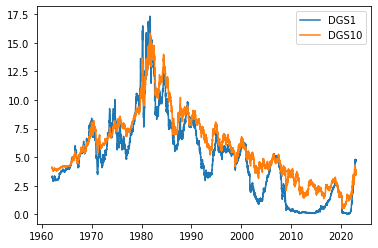

In [5]:
# plot data
for c in var_names[0:2]:
    plt.plot(df.index, df[c], label=c)
plt.legend()
plt.show()

In [9]:
# DoppelGANger requires multiple samples, so split up full series into samples with length equal to samp_size
samp_size = 125

# create fixed attributes
# label what example number each row will be assigned to
df['example_num'] = np.divmod(np.arange(len(df)),samp_size)[0]+1
# indicator for whether or not recession occurred in that example
recess_indic = df.groupby('example_num').max('USRECD')['USRECD']
df = df.drop(columns = ['example_num'])

# split time-series into many samples of size = samp_size and create array of features
# drop all fixed attributes from data
features = df.drop(columns=['USRECD']).to_numpy()
n = features.shape[0] // samp_size
features = features[:(n*samp_size),:].reshape(-1, samp_size, features.shape[1])
# shape of features array is (# examples, # time points, # features)
print(features.shape)

(121, 125, 2)


In [10]:
# NEED FIXED ATTRIBUTES (should not vary within each sample)
# create array of fixed attributes
attributes = recess_indic.to_numpy()
# ensure # of examples matches the # of examples in features array
attributes = attributes[:features.shape[0]]
attributes = attributes.reshape(attributes.shape[0], 1)
print(attributes.shape)

(121, 1)


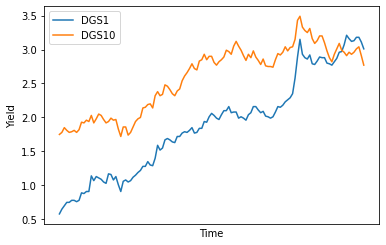

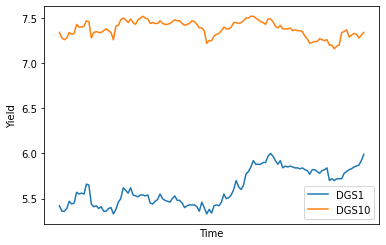

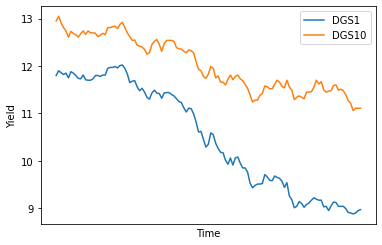

In [11]:
# display a few of the training samples
xaxis_days = np.array(range(1,samp_size+1))

def plot_day(f):
    for i, c in enumerate(var_names[0:2]):
        plt.plot(xaxis_days, f[:,i], label=c)
    ax = plt.gca()
    ax.xaxis.set_major_locator(md.HourLocator(byhour=range(2,24,3)))
    ax.xaxis.set_major_formatter(md.DateFormatter("%H:%M"))
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Yield")
    plt.show()

plot_day(features[120,:,:])
plot_day(features[30,:,:])
plot_day(features[45,:,:])

In [21]:
# configure DGAN
model = DGAN(DGANConfig(
    # length of training examples and of generated synthetic data
    max_sequence_len=features.shape[1],
    # max_sequence_len / sample_len should be an integer between 10-20 for best results
    sample_len= 5,
    batch_size=min(1000, features.shape[0]),
    apply_feature_scaling=True,
    apply_example_scaling=True,
    use_attribute_discriminator=True,
    generator_learning_rate=1e-4,
    discriminator_learning_rate=1e-4,
    epochs=10000,
))

# train model
model.train_numpy(
    attributes = attributes,
    features = features,
    feature_types= [OutputType.CONTINUOUS] * features.shape[2],
    attribute_types = [OutputType.DISCRETE] * attributes.shape[1]
)

In [25]:
# save model
# model.save('/content/drive/MyDrive/Models/DGAN1.pt')

In [12]:
# load previously trained model
if torch.cuda.is_available() == True:
  model = DGAN.load('/content/drive/MyDrive/Models/DGAN1.pt')
else:
  model = DGAN.load('/content/drive/MyDrive/Models/DGAN1.pt', map_location = torch.device('cpu'))

In [13]:
# generate synthetic data in numpy array format
synthetic_attributes, synthetic_features = model.generate_numpy(1000)

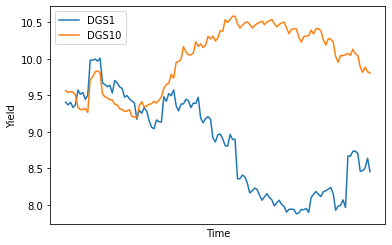

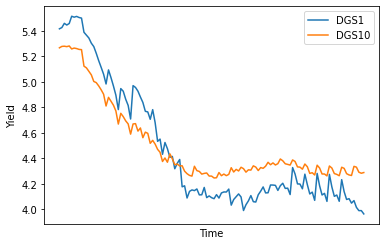

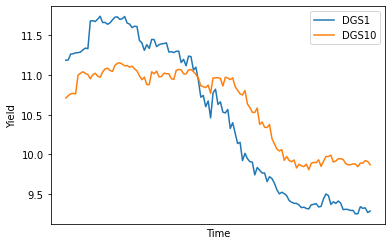

In [14]:
# show a few of synthetic samples generated
plot_day(synthetic_features[825,:,:])
plot_day(synthetic_features[42,:,:])
plot_day(synthetic_features[496,:,:])

Recession Indicator: [0]


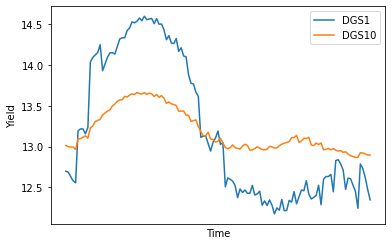

In [23]:
# pull random synthetic sample
lookup_num = np.random.randint(0, 1000)
print(f'Recession Indicator: {synthetic_attributes[lookup_num,:]}')
plot_day(synthetic_features[lookup_num,:,:])

Recession Indicator: [1.]


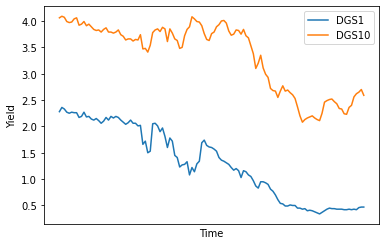

In [26]:
# pull random real sample
lookup_num = np.random.randint(0, features.shape[0])
print(f'Recession Indicator: {attributes[lookup_num,:]}')
plot_day(features[lookup_num,:,:])

In [27]:
# look at correlations between variables
synthetic_df = pd.DataFrame(synthetic_features.reshape(-1, synthetic_features.shape[2]), columns=var_names[0:2])

print("Correlation in real data:")
print(df.iloc[:,0:2].corr())
print()
print("Correlation in synthetic data:")
print(synthetic_df.corr())

Correlation in real data:
           DGS1     DGS10
DGS1   1.000000  0.948449
DGS10  0.948449  1.000000

Correlation in synthetic data:
           DGS1     DGS10
DGS1   1.000000  0.922576
DGS10  0.922576  1.000000


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


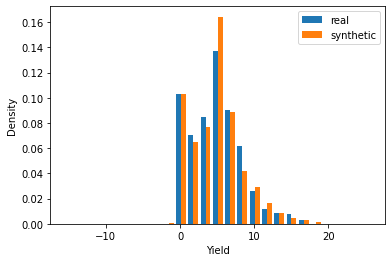

In [28]:
# Compare distribution of 10 year yields
plt.hist([features[:,:,0].flatten(), synthetic_features[:,:,0].flatten()], 
         label=["real", "synthetic"],
         bins=25,
         density=True)
plt.legend()
plt.xlabel("Yield")
plt.ylabel("Density")
plt.show()

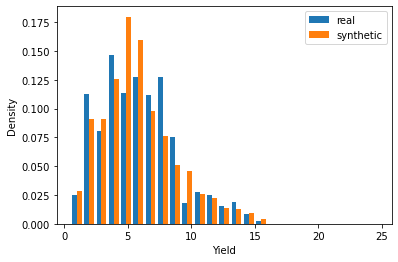

In [29]:
# Compare distribution of 1 year yields
plt.hist([features[:,:,1].flatten(), synthetic_features[:,:,1].flatten()], 
         label=["real", "synthetic"],
         bins=25,
         density=True)
plt.legend()
plt.xlabel("Yield")
plt.ylabel("Density")
plt.show()

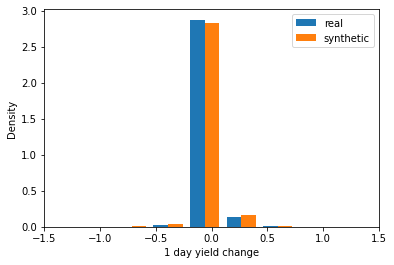

In [35]:
# Compare distribution of 1-step change for 10 year yield
real_diffs = np.diff(features, axis=1)
synthetic_diffs = np.diff(synthetic_features, axis=1)

plt.hist([real_diffs[:,:,0].flatten(), synthetic_diffs[:,:,0].flatten()],
         label=["real", "synthetic"],
         bins=50,
         density=True)
plt.legend()
plt.xlabel("1 day yield change")
plt.ylabel("Density")
plt.xlim([-1.5, 1.5])
plt.show()

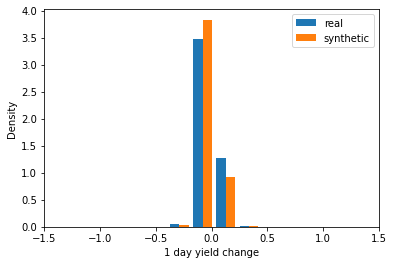

In [36]:
# Compare distribution of 1-step change for 1 year yield
real_diffs = np.diff(features, axis=1)
synthetic_diffs = np.diff(synthetic_features, axis=1)

plt.hist([real_diffs[:,:,1].flatten(), synthetic_diffs[:,:,1].flatten()],
         label=["real", "synthetic"],
         bins=50,
         density=True)
plt.legend()
plt.xlabel("1 day yield change")
plt.ylabel("Density")
plt.xlim([-1.5, 1.5])
plt.show()

In [37]:
# get average autocorrelation across all synthetic replicates
def get_synth_autocorr(synth_np, column_num, nlags):
  # filter on single variable in synth_np based on column_num
  synth_var = synth_np[:,:,column_num]
  # get autocorrelation values for each synthetic sample
  autocorr_vals = np.apply_along_axis(sm.tsa.acf, 1, synth_var, 
                                      fft = True, nlags = nlags)
  # average autocorrelation values across samples
  return(np.apply_along_axis(np.mean, 0, autocorr_vals))

# set number of desired lags
lags = 40

# get synthetic autocorrelations for both variables
synth_auto_1 = get_synth_autocorr(synthetic_features, 0, nlags = lags)
synth_auto_10 = get_synth_autocorr(synthetic_features, 1, nlags = lags)

# get true autocorrelations for both variables
true_auto_1 = sm.tsa.acf(df['DGS1'], nlags = lags, fft = True)
true_auto_10 = sm.tsa.acf(df['DGS10'], nlags = lags, fft = True)

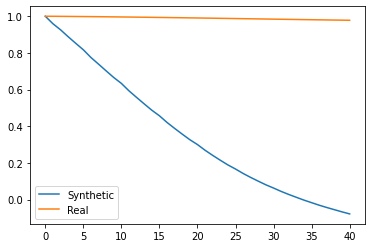

In [38]:
#plot autocorrelations for 1 year and synthetic
plt.plot(synth_auto_1, label = 'Synthetic')
plt.plot(true_auto_1, label = 'Real')
plt.legend()
plt.show()

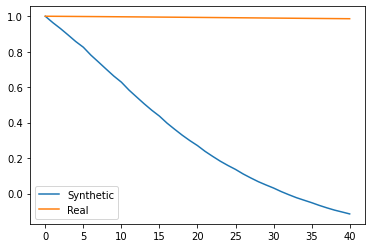

In [39]:
#plot autocorrelations for 10 year and synthetic
plt.plot(synth_auto_10, label = 'Synthetic')
plt.plot(true_auto_10, label = 'Real')
plt.legend()
plt.show()

In [63]:
# save and output data to drive
df.to_csv("/content/drive/MyDrive/Synthetic_data/fred_data")
np.savetxt("/content/drive/MyDrive/Synthetic_data/synthetic_attributes", synthetic_attributes)

In [56]:
# reshape multidimensional numpy arrays so they can be saved (must return to original shape when loading)
print(f'synthetic_features original shape: {synthetic_features.shape}')
synthetic_features_reshape = synthetic_features.reshape(synthetic_features.shape[0], -1)
np.savetxt("/content/drive/MyDrive/Synthetic_data/synthetic_features_reshaped", synthetic_features_reshape)

synthetic_features original shape: (1000, 125, 2)


In [40]:
#### example for loading and reshaping
# test = np.loadtxt("/content/drive/MyDrive/Synthetic_data/synthetic_features_reshaped")
# test_orig = test.reshape(1000, 125, 2)
# (test_orig == synthetic_features).all()